In [2]:
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')

# Data

Load stock prices and results from the MATLAB script

Stocks prices: divide in 4 years of train and 2 years of test

In [3]:
stocks = pd.read_csv('data/stocks.csv', index_col='Unnamed: 0', parse_dates=True)

# date from 2014-01-02 to 2018-12-31 
train = stocks['2014-01-02':'2018-12-31']
# date from 2019-01-01 to 2021-12-31
test = stocks['2019-01-01':'2021-12-31']

# normalize data
train = train / train.iloc[0]
test = test / test.iloc[0]

# fill missing values with the previous value
train = train.ffill()
test = test.ffill()
test.head(2)

,AEP,GT,COTY,AZO,HON,IRM,REG,CE,UPS,LNT,...,MSI,CPRI,AIZ,KSS,TGT,DD,ANSS,SPG,JWN,STZ
2019-01-02,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.00000,1.000000
2019-01-03,0.997669,0.982583,0.976978,1.008468,0.986649,1.015888,1.001408,0.963491,0.971608,1.001701,...,0.964976,0.952528,0.984018,0.978909,0.986303,0.963133,0.96245,0.999152,0.98989,0.985126


Efficient frontier results

In [6]:
eff_col = ['returns', 'risk'] + [i for i in stocks.columns]
eff = pd.read_csv('data/efficient_frontier_weights.csv', names=eff_col, header=None)
eff_weights = eff.iloc[:, 2:]
eff_weights.head(2)

,AEP,GT,COTY,AZO,HON,IRM,REG,CE,UPS,LNT,...,MSI,CPRI,AIZ,KSS,TGT,DD,ANSS,SPG,JWN,STZ
0,2.340024e-13,1.659095e-13,2.753400e-13,2.300677e-13,2.196957e-13,2.248543e-13,1.993782e-13,2.347592e-13,1.588577e-13,2.352826e-13,...,2.355627e-13,2.711582e-13,2.080469e-13,2.261193e-13,1.638614e-13,2.005027e-13,2.223586e-13,1.851440e-13,1.550082e-13,2.525789e-13
1,5.542622e-13,5.299490e-13,5.334673e-13,5.552420e-13,5.677236e-13,5.626611e-13,5.768031e-13,5.694256e-13,5.402008e-13,5.547705e-13,...,5.565784e-13,5.360426e-13,5.763025e-13,5.644601e-13,5.801356e-13,5.899694e-13,5.634618e-13,5.796268e-13,5.540178e-13,5.580838e-13


PSO results

In [7]:
pso_col = ['lambda', 'risk', 'returns']+ [i for i in stocks.columns]
pso = pd.read_csv('data/PSO_portfolios.csv', names=pso_col, header=None)
pso_weights = pso.iloc[:, 3:]
#revert the index (from low to high risk)
pso_weights = pso_weights.reindex(index=pso_weights.index[::-1])
pso_weights.head(2)

,AEP,GT,COTY,AZO,HON,IRM,REG,CE,UPS,LNT,...,MSI,CPRI,AIZ,KSS,TGT,DD,ANSS,SPG,JWN,STZ
49,0,0.0,0,0,0,0.0,0.0,0.0,0,0.0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48,0,0.0,0,0,0,0.0,0.0,0.0,0,0.0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Results

## Portfolios from efficient frontier

In [9]:
# pick few selected efficient portfolios
num_selected = 6
selected_eff = [i for i in range(1,len(eff_weights), len(eff_weights)//(num_selected))]
selected_eff

[1, 84, 167, 250, 333, 416, 499]

Evolution of the portfolio value with the efficient frontier weights in train

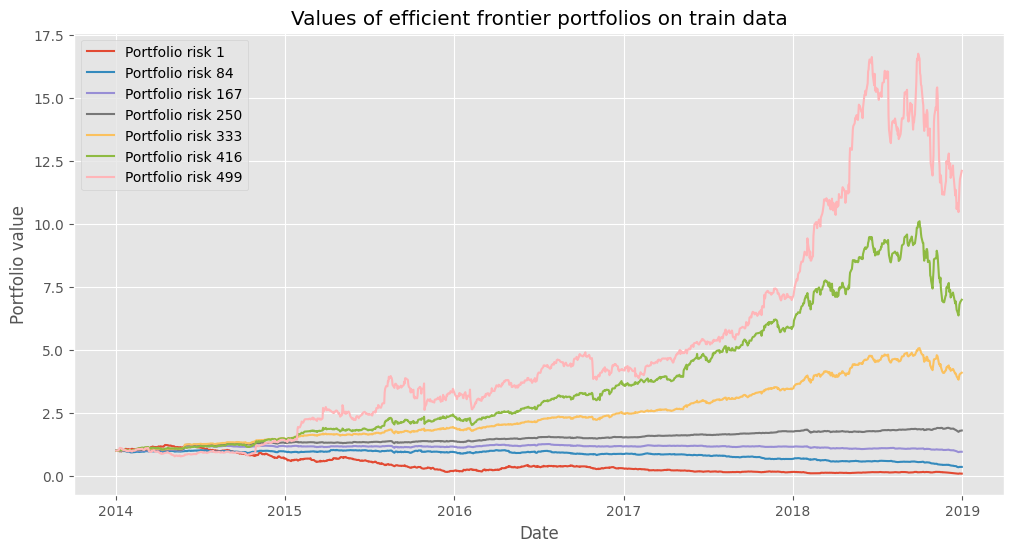

In [48]:
eff_train = train.values @ eff_weights.T.values

plt.figure(figsize=(12, 6))
for i in selected_eff:
    plt.plot(train.index, eff_train[:, i], label='Portfolio risk '+ str(i))
plt.legend()
plt.title('Values of efficient frontier portfolios on train data')
plt.xlabel('Date')
plt.ylabel('Portfolio value')
plt.show()

Evolution of the portfolio value with the efficient frontier weights in test

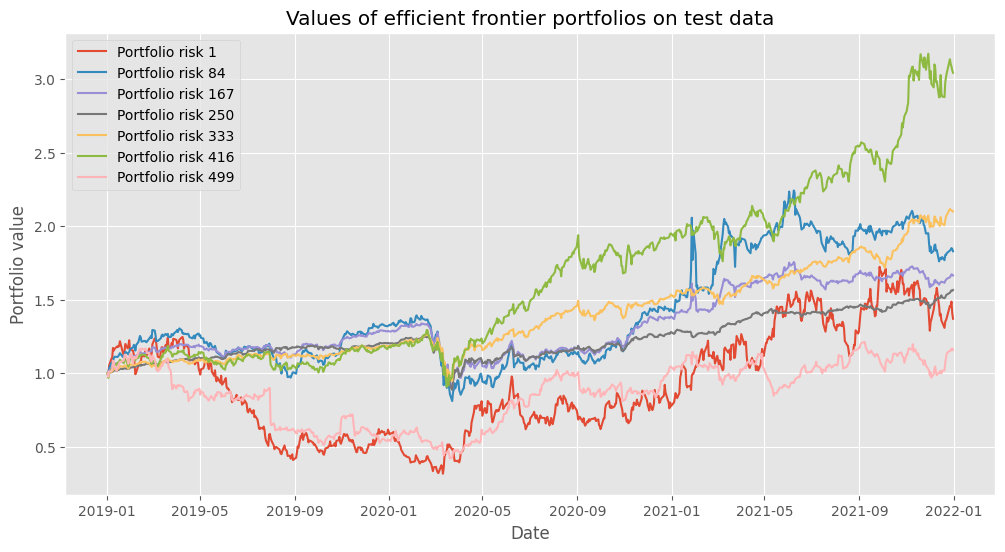

In [52]:
eff_test = test.values @ eff_weights.T.values

plt.figure(figsize=(12, 6))
for i in selected_eff:
    plt.plot(test.index, eff_test[:, i], label='Portfolio risk '+str(i))
plt.legend()
plt.title('Values of efficient frontier portfolios on test data')
plt.xlabel('Date')
plt.ylabel('Portfolio value')
plt.show()

Table of risk metrics on test of the selected portfolios

In [53]:
risk_metrics = pd.DataFrame(index=selected_eff, columns=['Risk', 'Return', 'Sharpe ratio'])
for i in selected_eff:
    risk_metrics.loc[i, 'Risk'] = (test.values @ eff_weights.iloc[i].values).std()*100/2
    risk_metrics.loc[i, 'Return'] = (test.values @ eff_weights.iloc[i].values)[-1]*100/2
    risk_metrics.loc[i, 'Sharpe ratio'] = risk_metrics.loc[i, 'Return'] / risk_metrics.loc[i, 'Risk']
    risk_metrics.loc[i, 'Max Drawdown'] = (1-(test.values @ eff_weights.iloc[i].values).min())*100
risk_metrics

,Risk,Return,Sharpe ratio,Max Drawdown
1,18.044023,68.555258,3.799333,68.250318
84,18.510614,91.47088,4.941537,18.852791
167,11.155592,83.253337,7.462924,10.642947
250,7.143216,78.29621,10.960919,11.266302
333,14.699553,104.992425,7.142559,5.139963
416,29.160835,152.171651,5.218357,9.226029
499,10.284474,57.938126,5.633552,57.894567


## Portfolios from PSO

In [54]:
# pick few selected pso portfolios
# num_selected = 6
# selected_pso = [i for i in range(1,len(pso_weights), len(pso_weights)//(num_selected))]
# selected_pso
selected_pso = [0, 12, 24, 37, 47]

Evolution of the portfolio value with the PSO weights in train

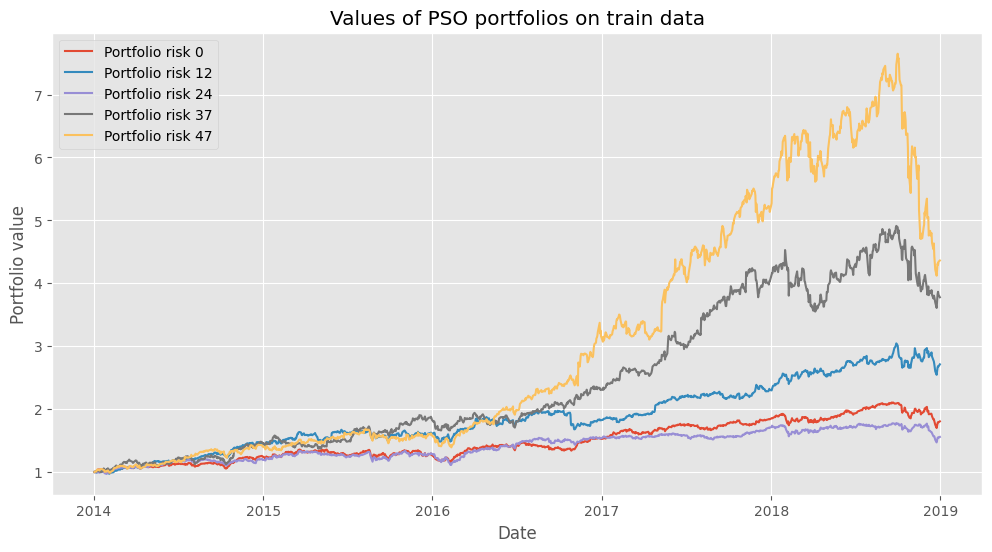

In [55]:
pso_train = train.values @ pso_weights.T.values

plt.figure(figsize=(12, 6))
for i in selected_pso:
    plt.plot(train.index, pso_train[:, i], label='Portfolio risk '+str(i))
plt.legend()
plt.title('Values of PSO portfolios on train data')
plt.xlabel('Date')
plt.ylabel('Portfolio value')
plt.show()

Evolution of the portfolio value with the PSO weights in test

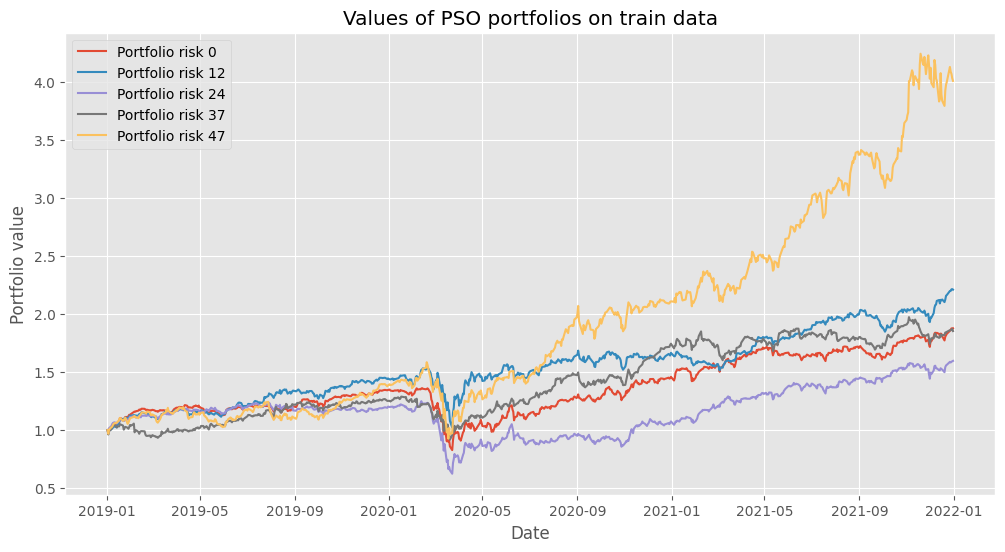

In [56]:
pso_test = test.values @ pso_weights.T.values

plt.figure(figsize=(12, 6))
for i in selected_pso:
    plt.plot(test.index, pso_test[:, i], label='Portfolio risk '+str(i))
plt.legend()
plt.title('Values of PSO portfolios on train data')
plt.xlabel('Date')
plt.ylabel('Portfolio value')
plt.show()

In [57]:
# table of risk metrics on test of the selected portfolios
risk_metrics = pd.DataFrame(index=selected_pso, columns=['Risk', 'Return', 'Sharpe ratio'])
for i in selected_pso:
    risk_metrics.loc[i, 'Risk'] = (test.values @ pso_weights.iloc[i].values).std()*100/2
    risk_metrics.loc[i, 'Return'] = (test.values @ pso_weights.iloc[i].values)[-1]*100/2
    risk_metrics.loc[i, 'Sharpe ratio'] = risk_metrics.loc[i, 'Return'] / risk_metrics.loc[i, 'Risk']
    risk_metrics.loc[i, 'Max Drawdown'] = (1-(test.values @ pso_weights.iloc[i].values).min())*100
risk_metrics

,Risk,Return,Sharpe ratio,Max Drawdown
0,11.834174,93.803091,7.926459,17.211153
12,14.180326,110.462617,7.78985,2.268161
24,9.764195,79.796287,8.172337,37.545297
37,15.515947,92.638876,5.970559,8.303667
47,43.068238,200.298019,4.650713,7.369209


## Frontier and pso distribution

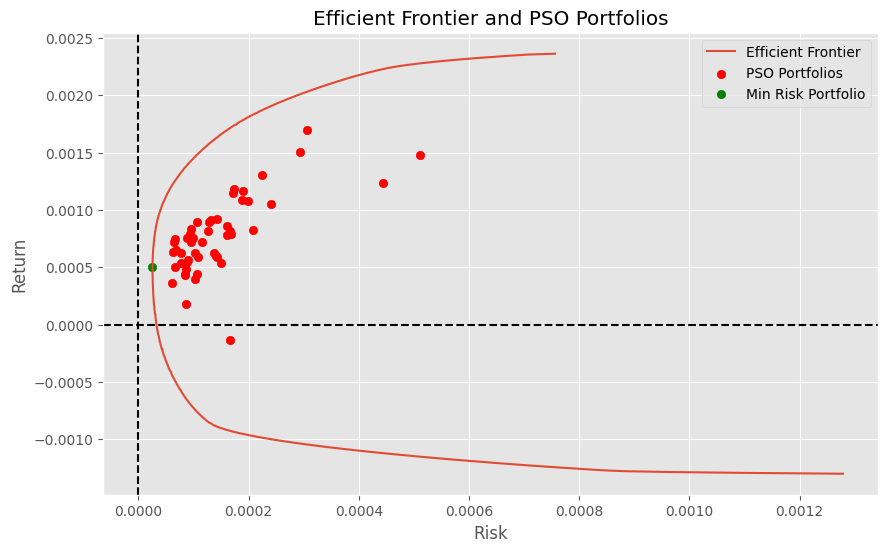

In [58]:
min_risk_index = eff['risk'].idxmin()

# plot efficient frontier and PSO portfolios    
plt.figure(figsize=(10, 6))
plt.plot(eff.risk, eff.returns, label='Efficient Frontier')
plt.scatter(pso.risk, pso.returns, c='red', label='PSO Portfolios')
plt.axhline(y=0, color='black', linestyle='--')
plt.axvline(x=0, color='black', linestyle='--')
# min risk portfolio
plt.scatter(eff.risk[min_risk_index], eff.returns[min_risk_index], c='green', label='Min Risk Portfolio')
plt.xlabel('Risk')
plt.ylabel('Return')
plt.title('Efficient Frontier and PSO Portfolios')
plt.legend()
plt.show()

## Minimum risk portfolio

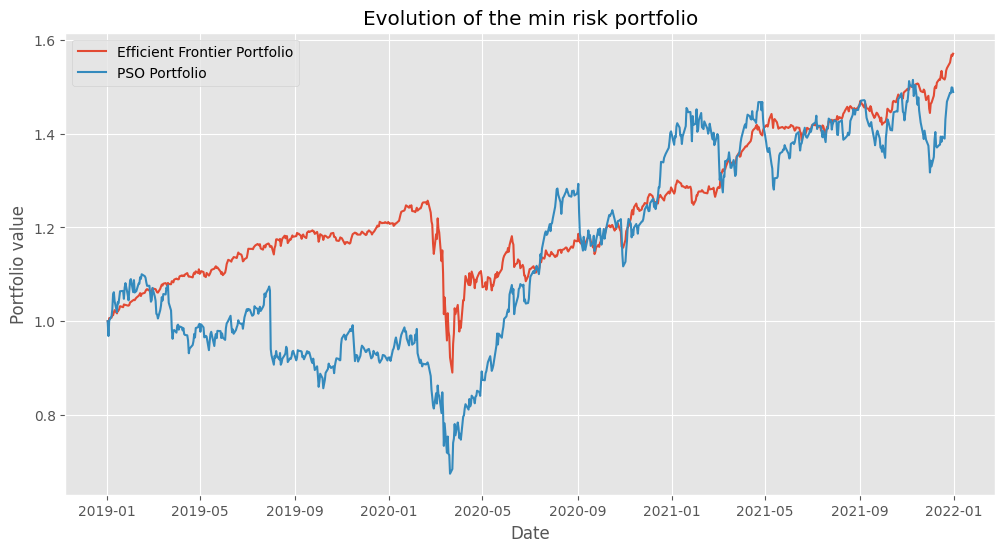

In [19]:
# PSO portfolio with the minimum risk
min_risk_pso_index = pso['risk'].idxmin()

# compare the evolution of the min risk portfolio with the min risk portfolio of the efficient frontier
plt.figure(figsize=(12, 6))
plt.plot(test.index, eff_test[:, min_risk_index], label='Efficient Frontier Portfolio')
plt.plot(test.index, pso_test[:, min_risk_pso_index], label='PSO Portfolio')
plt.legend()
plt.title('Evolution of the min risk portfolio')
plt.xlabel('Date')
plt.ylabel('Portfolio value')
plt.show()

## Maximum return portfolio

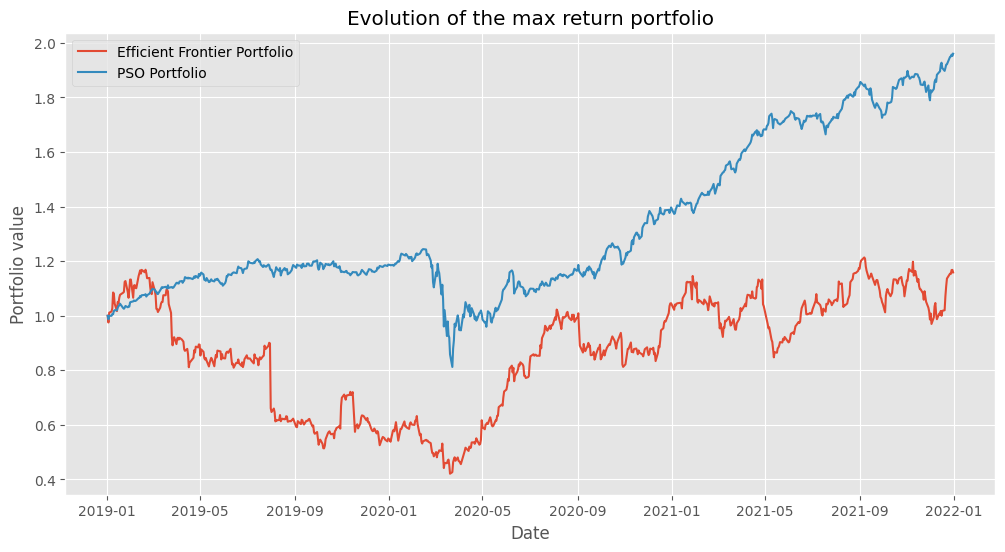

In [20]:
# compare the evolution of the max return portfolio with the max return portfolio of the efficient frontier
max_return_pso_index = pso['returns'].idxmax()

plt.figure(figsize=(12, 6))
plt.plot(test.index, eff_test[:, eff['returns'].idxmax()], label='Efficient Frontier Portfolio')
plt.plot(test.index, pso_test[:, max_return_pso_index], label='PSO Portfolio')
plt.legend()
plt.title('Evolution of the max return portfolio')
plt.xlabel('Date')
plt.ylabel('Portfolio value')
plt.show()